# News impact on stock price return at Warsaw Stock Exchange

***
## Part I: introduction

### Project description
***Draft:***

The projects aims to verify the impact of the news published on official WSE news website, infostrefa.com on stock price return.



### Prerequisites



#### import necessary libraries and modules

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import nltk
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt

from pprint import pprint

#### ***optional***: modify pandas display options

In [2]:
pd.set_option('display.max_rows',500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = "{:.4f}".format

#### import data

Please note that due to lack of default dictionary of Polish stop worods in nltk 
a custom solution had to be put in place. The custom-made dictionary is a combination of two lists:

1) a list of common Polish stop words, found on:
https://github.com/bieli/stopwords/blob/master/polish.stopwords.txt

2) a list frequent words used in news titles

In order to use the custom dictionary, please copy 'polish_modified' file into nltk stopwords directory,
which usuallu is '/USER/nltk_data/corpora/stopwords/'
'''


In [3]:
News = pd.read_csv("NewsWithMarketReturns",sep=";",parse_dates=["Timestamp"])
StopWords = set(stopwords.words('polish_modified'))
News.head(15)

,Unnamed: 0,Timestamp,Title,Profile,Exception-1M,Exception-1W,Exception-1D,Exception-1H,Exception-5m,Exception+5m,Exception+1H,Exception+1D,Exception+1W,Exception+1M,Company_-1M,Company_-1W,Company_-1D,Company_-1H,Company_-5m,Company_+5m,Company_+1H,Company_+1D,Company_+1W,Company_+1M,Market_-1M,Market_-1W,Market_-1D,Market_-1H,Market_-5m,Market_+5m,Market_+1H,Market_+1D,Market_+1W,Market_+1M,Diff-1M,Diff-1W,Diff-1D,Diff-1H,Diff-5m,Diff+5m,Diff+1H,Diff+1D,Diff+1W,Diff+1M
0,0,2017-12-29 14:33:00,TAURON POLSKA ENERGIA SA (43/2017) Podpisanie aneksu do porozumienia w sprawie potencjalnej współpracy przy realizacji projektu budowy bloku energetycznego 910 MW w Jaworznie,TAURONPE,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,-0.0100,0.0200,0.0100,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0500,nan,0.0181,0.0084,0.0008,-0.0002,0.0002,-0.0002,-0.0032,0.0000,0.0252,nan,-0.0281,0.0116,0.0092,0.0002,-0.0002,0.0002,0.0032,0.0000,0.0248,nan
1,1,2017-12-28 19:47:00,GPW: wprowadzenie do obrotu obligacji ALIOR BANK SA,ALIOR,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0700,0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0200,nan,0.0079,0.0060,-0.0020,0.0000,0.0000,0.0000,0.0000,-0.0052,0.0245,nan,0.0621,0.0040,0.0020,0.0000,0.0000,0.0000,0.0000,0.0052,-0.0445,nan
2,2,2017-12-27 18:22:00,GPW: w sprawie wprowadzenia do obrotu na Catalyst obligacji serii B spółki POLSKI KONCERN NAFTOWY ORLEN S.A.,PKNORLEN,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,-0.0800,0.0500,0.0200,0.0000,0.0000,0.0000,0.0000,-0.0300,-0.0700,nan,0.0143,0.0067,0.0131,0.0000,0.0000,0.0000,0.0000,-0.0002,-0.0029,nan,-0.0943,0.0433,0.0069,0.0000,0.0000,0.0000,0.0000,-0.0298,-0.0671,nan
3,3,2017-12-27 09:20:00,"ME modyfikuje rozporządzenie ws taryfy nocnej, zmienia zasady korzystania",ENERGA,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0100,-0.0000,0.0100,-0.0100,0.0000,0.0000,-0.0000,0.0200,0.0300,nan,0.0075,-0.0024,0.0013,0.0068,0.0003,-0.0010,-0.0005,0.0014,0.0016,nan,-0.0175,0.0024,0.0087,-0.0168,-0.0003,0.0010,0.0005,0.0186,0.0284,nan
4,4,2017-12-28 15:03:00,Część instalacji POX w Unipetrolu wróciła do eksploatacji po pożarze,PKNORLEN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,-0.0700,0.0100,-0.0100,-0.0000,-0.0000,0.0000,-0.0100,-0.0400,-0.0400,nan,0.0070,0.0038,0.0001,-0.0009,-0.0022,0.0004,0.0010,0.0050,0.0307,nan,-0.0770,0.0062,-0.0101,0.0009,0.0022,-0.0004,-0.0110,-0.0450,-0.0707,nan
5,5,2017-12-22 23:50:00,ALIOR BANK SA (90/2017) Dopuszczenie obligacji serii P2A do obrotu na rynku podstawowym,ALIOR,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0500,0.0300,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0100,nan,-0.0084,0.0120,-0.0056,0.0000,0.0000,0.0000,0.0000,0.0000,0.0064,nan,0.0584,0.0180,0.0056,0.0000,0.0000,0.0000,0.0000,0.0000,0.0036,nan
6,6,2017-12-22 12:54:00,PGE rozpoczęła testy na utratę wartości aktywów majątku wytwórczego konwencjonalnego i OZE,PGE,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,-0.0400,-0.0200,-0.0000,-0.0000,-0.0000,0.0000,-0.0100,0.0000,0.0100,nan,0.0009,0.0093,-0.0018,-0.0003,0.0001,-0.0004,-0.0005,0.0000,0.0088,nan,-0.0409,-0.0293,0.0018,0.0003,-0.0001,0.0004,-0.0095,0.0000,0.0012,nan
7,7,2017-12-22 14:08:00,OFE PZU Złota Jesień informuje,PZU,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,-0.1300,-0.0400,-0.0200,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0100,nan,0.0024,0.0104,-0.0021,0.0005,0.0000,-0.0001,0.0007,0.0000,0.0090,nan,-0.1324,-0.0504,-0.0179,-0.0005,-0.0000,0.0001,-0.0007,0.0000,0.0010,nan
8,8,2017-12-22 20:22:00,GPW: dopuszczenie do obrotu obligacji spółki ALIOR BANK S.A.,ALIOR,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0500,0.0300,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0100,nan,-0.0084,0.0120,-0.0056,0.0000,0.0000,0.0000,0.0000,0.0000,0.0064,nan,0.0584,0.0180,0.0056,0.0000,0.0000,0.0000,0.0000

### News table description

| Column Name 	| Contents 	|
|----------------------	|--------------------------------------------------------------------------	|
| Timestamp 	| The exact moment the news was published 	|
| Title 	| Title of the news 	|
| Profile 	| Copmany the news refers to 	|
| Exception (-1M to +1M) 	| Include/Exclude news from analysis for the period given 	|
| Company (-1M to +1M) 	| Log return of the Company stock for the period given 	|
| Market (-1M to +1M) 	| Log market return for the period given 	|
| Diff (-1M to +1M) 	| Difference between Company stock return and Market return for the period given 	|

___
**Returns**

All returns are logarythmic returns between the prices at the time of news release (T0) and T+i where i indicates an interval (plus or minus 5 minutes, 1 hour, 1 day, 1 week or 1 month).

If the news was released out of 9:00-17:00 trading hours or on a non trading day (weekends and holidays), last available price is considered to be a T0 price.

**Exceptions**

All cases where T+i timestamp falls outside trading period are excluded for analysis for a given interval (e.g. for news released on 2017-09-15 at 15:30 a T-1M timestamp would be 2017-08-15 which is a holiday)

The rationale behind such limitation is that all intervals should be consistent in length so that Company vs Market returns are comparable.

***
## Part II: Cleaning dataset

#### Extract news content into separate dataframe

In [4]:
Message = pd.DataFrame(News.Title)

### Basic features

#### Number of words, characters (including spaces) and stopwords

In [5]:
Message['WordCount']=Message['Title'].apply(lambda x: len(str(x).split(" ")))
Message['CharCount'] = Message['Title'].str.len()
Message['StopWordsCount'] = Message['Title'].apply(lambda x: len([x for x in str(x).split() if x in StopWords]))
Message['Numerics'] = Message['Title'].apply(lambda x: len([x for x in str(x).split() if x.isdigit()]))

In [6]:
Message.describe().reset_index()

,index,WordCount,CharCount,StopWordsCount,Numerics
0,count,20644.0000,20644.0000,20644.0000,20644.0000
1,mean,12.0571,77.2181,2.5743,0.2722
2,std,4.6887,30.7654,1.8075,0.5542
3,min,2.0000,14.0000,0.0000,0.0000
4,25%,9.0000,58.0000,1.0000,0.0000
5,50%,12.0000,75.0000,2.0000,0.0000
6,75%,15.0000,90.0000,3.0000,0.0000
7,max,46.0000,255.0000,12.0000,6.0000


##### Observation

There's a number of titles with unexpectedly low word count, the following table shows those with word count <=3:

In [7]:
Message.Title[Message.WordCount<=3].reset_index()

,index,Title
0,521,Porozmawiajmy o inwestycjach
1,1452,GRUPA LOTOS SA
2,4319,OFE PZU informuje
3,4320,OFE PZU informuje
4,10152,GPW: MBANK S.A.
5,10846,GPW: Komunikat
6,12628,OFE PZU informuje
7,12651,OFE PZU informuje
8,12690,OFE PZU informuje
9,12772,OFE PZU informuje


##### Conclusion

The shortest titles seem to be generic PZU pension fund information or irrelevant noise

**Therefore, all such cases will be deleted.**

In [8]:
Message = Message[Message["WordCount"]>3]

### Removing unnecessary words and characters

#### Verify if there are any recurring phrases or words other than generic stopwords

In [9]:
DataSet = Message["Title"].str.cat(sep='; ')

SplitWords = DataSet.split(" ")
SplitPhrases = DataSet.split(",")
 

SplitWordsCounter = Counter(SplitWords)
SplitPhrasesCounter = Counter(SplitPhrases)

MostCommonWords = pd.DataFrame(SplitWordsCounter.most_common(50))
MostCommonPhrases = pd.DataFrame(SplitPhrasesCounter.most_common(50))

In [10]:
MostCommonWords

,0,1
0,SA,7425
1,w,7009
2,na,4770
3,do,3178
4,z,3081
5,PZU,2913
6,-,2872
7,ORLEN,2503
8,przez,2485
9,i,2478


In [11]:
MostCommonPhrases

,0,1
0,5 mln zł,43
1,4 mln zł,42
2,2 mln zł,42
3,6 mln zł,40
4,czyli 0,35
5,8 mln zł,32
6,KGHM,26
7,3 mln zł,26
8,Enea,25
9,9 mln zł,23


##### Observation

There's a number of words and phrases that occur frequently that seem to be generic for financial market related news or actual company names. These cases will therefore be deleted. 

#### Delete non-default stop words and phrases

In [12]:
AdditionalStopPhrases = np.array(MostCommonPhrases[0])
AdditionalStopWords = np.array(MostCommonWords[0])

In [13]:
Message['Title'] = Message['Title'].apply(lambda x: " ".join(x for x in str(x).split(",") if x not in AdditionalStopPhrases))

In [14]:
Message['Title'] = Message['Title'].apply(lambda x: " ".join(x for x in str(x).split(" ") if x not in AdditionalStopWords))

#### Convert content to lower case, remove punctuation, numerics and default stopwords

In [15]:
#lower case
Message['Title'] = Message['Title'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

In [16]:
#remove punctuation
Message['Title'] = Message['Title'].str.replace('[^\w\s]','')

In [17]:
#remove numerics
Message['Title'] = Message['Title'].str.replace('[^\D]','')

In [18]:
#remove default stopwords
Message['Title'] = Message['Title'].apply(lambda x: " ".join(x for x in str(x).split(" ") if x not in StopWords))

#### Recalculate the number of words, characters (including spaces), stopwords and numerics

In [19]:
Message['WordCount']=Message['Title'].apply(lambda x: len(str(x).split(" ")))
Message['CharCount'] = Message['Title'].str.len()
Message['StopWordsCount'] = Message['Title'].apply(lambda x: len([x for x in str(x).split() if x in StopWords]))
Message['Numerics'] = Message['Title'].apply(lambda x: len([x for x in str(x).split() if x.isdigit()]))

In [20]:
Message.describe().reset_index()

,index,WordCount,CharCount,StopWordsCount,Numerics
0,count,20563.0000,20563.0000,20563.0000,20563.0000
1,mean,5.6044,41.9288,0.0000,0.0000
2,std,2.9844,26.2793,0.0000,0.0000
3,min,1.0000,0.0000,0.0000,0.0000
4,25%,4.0000,24.0000,0.0000,0.0000
5,50%,6.0000,40.0000,0.0000,0.0000
6,75%,7.0000,57.0000,0.0000,0.0000
7,max,27.0000,230.0000,0.0000,0.0000


***
## Part III: Modelling topics

The following code uses functions from the article:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#8tokenizewordsandcleanuptextusingsimple_preprocess

#### Tokenize

In [21]:
def tokenize(wordlist):
    for word in wordlist:
        yield(gensim.utils.simple_preprocess(str(word),
                                             min_len=3, 
                                             max_len=25, 
                                             deacc=True))

In [22]:
WordsTokenized = list(tokenize(Message.Title))

#### Create bigrams and trigrams

In [23]:
bigram = gensim.models.Phrases(WordsTokenized, 
                               min_count=2, 
                               threshold=8) 

trigram = gensim.models.Phrases(bigram[WordsTokenized], 
                                min_count=3, 
                                threshold=8)  

/anaconda3/lib/python3.5/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [24]:
def create_bigrams(wordlist):
    return [bigram[i] for i in wordlist]

def create_trigrams(wordlist):
    return [trigram[bigram[i]] for i in wordlist]


In [25]:
WordsTokenized = create_bigrams(WordsTokenized)
WordsTokenized = create_trigrams(WordsTokenized)

/anaconda3/lib/python3.5/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


#### Create corpus and dictionary

In [26]:
Dict = corpora.Dictionary(WordsTokenized)
Corp = [Dict.doc2bow(word) for word in WordsTokenized]

##### Print part of corpus

In [27]:
[[(Dict[i], frequency) for i, frequency in corp] for corp in Corp[:100]]

[[('aneksu', 1),
  ('budowy_energetycznego', 1),
  ('energia_podpisanie', 1),
  ('porozumienia', 1),
  ('potencjalnej', 1),
  ('realizacji_projektu', 1),
  ('sprawie', 1),
  ('wspołpracy', 1)],
 [('wprowadzenie_obrotu', 1)],
 [('sprawie', 1), ('catalyst', 1), ('wprowadzenia_obrotu', 1)],
 [('korzystania', 1),
  ('modyfikuje', 1),
  ('nocnej', 1),
  ('rozporzadzenie', 1),
  ('taryfy', 1),
  ('zasady', 1),
  ('zmienia', 1)],
 [('czesc', 1),
  ('eksploatacji', 1),
  ('instalacji', 1),
  ('pox', 1),
  ('pozarze', 1),
  ('wrociła', 1)],
 [('dopuszczenie_obrotu_rynku_podstawowym', 1)],
 [('konwencjonalnego', 1),
  ('majatku', 1),
  ('oze', 1),
  ('rozpoczeła', 1),
  ('testy_utrate', 1),
  ('wartosci_aktywow', 1),
  ('wytworczego', 1)],
 [('informuje', 1)],
 [('dopuszczenie_obrotu', 1)],
 [('gruzji', 1),
  ('kazachstanu', 1),
  ('kupic', 1),
  ('rumunii', 1),
  ('sklepy', 1),
  ('wchodzi', 1)],
 [('nadzwyczajnego_walnego_zgromadzenia_projekty', 1),
  ('społka_weglowa_ogłoszenie_zwołaniu', 1),

### LDA model

#### Find optimal parameters number

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=Corp,
                                           id2word=Dict,
                                           num_topics=num_topics, chunksize=100
                                       )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [29]:
model_list, coherence_values = compute_coherence_values(dictionary=Dict,
                                                        corpus=Corp,
                                                        texts=WordsTokenized,
                                                        start=2,
                                                        limit=30,
                                                        step=1)

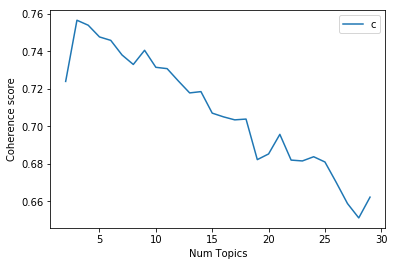

In [30]:
limit=30; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7239
Num Topics = 3  has Coherence Value of 0.7565
Num Topics = 4  has Coherence Value of 0.7538
Num Topics = 5  has Coherence Value of 0.7476
Num Topics = 6  has Coherence Value of 0.7458
Num Topics = 7  has Coherence Value of 0.738
Num Topics = 8  has Coherence Value of 0.7329
Num Topics = 9  has Coherence Value of 0.7405
Num Topics = 10  has Coherence Value of 0.7314
Num Topics = 11  has Coherence Value of 0.7307
Num Topics = 12  has Coherence Value of 0.7241
Num Topics = 13  has Coherence Value of 0.7178
Num Topics = 14  has Coherence Value of 0.7185
Num Topics = 15  has Coherence Value of 0.707
Num Topics = 16  has Coherence Value of 0.705
Num Topics = 17  has Coherence Value of 0.7034
Num Topics = 18  has Coherence Value of 0.7038
Num Topics = 19  has Coherence Value of 0.6822
Num Topics = 20  has Coherence Value of 0.6853
Num Topics = 21  has Coherence Value of 0.6957
Num Topics = 22  has Coherence Value of 0.682
Num Topics = 23  has Cohe

#### Run LDA model for optimal number of topics

Coherence scores is maximized for 4 topic numbers and decrease sharply for topic numbers greater than 6. Although 4 is too small, 10 appears to be an optimal number: it ensures both topic diversity and relatively high coherence score.

In [32]:
OptimalTopicNumber = 10

In [33]:
LDAModel = gensim.models.ldamodel.LdaModel(corpus=Corp,
                                           id2word=Dict,
                                           num_topics=OptimalTopicNumber, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#### Print topics

In [34]:
pprint(LDAModel.print_topics())

[(0,
  '0.030*"analiza" + 0.029*"trzymaj" + '
  '0.028*"transakcje_akcjach_dokonane_blisko" + 0.020*"gazu_łupkow" + '
  '0.015*"zwiazana_członkiem_rady_nadzorczej" + 0.015*"projekt" + '
  '0.015*"koniec_miał_stacji_paliw" + 0.014*"podnosi" + '
  '0.013*"zwiazana_członkiem" + 0.013*"prognoz"'),
 (1,
  '0.024*"dokonał_zmian_rekomendacjach_społek" + 0.022*"sprzedazy" + '
  '0.019*"podniosł_rekomendacje" + 0.015*"zmienił_ceny_docelowe_bankow" + '
  '0.015*"wyniki" + 0.013*"zysku" + 0.011*"obnizył_podwyzszył" + '
  '0.011*"ocenia" + 0.010*"puławy" + 0.009*"wspołpracy"'),
 (2,
  '0.050*"zmienił_rekomendacje_społek" + 0.041*"obnizył_cene_docelowa" + '
  '0.030*"komunikat" + 0.024*"kupuj" + '
  '0.021*"łupkowego_ministerstwo_srodowiska" + 0.015*"ceny_docelowe" + '
  '0.015*"akcje" + 0.015*"sprzedaj" + 0.011*"dwoch" + '
  '0.011*"rekomenduje_sprzedaj"'),
 (3,
  '0.072*"bank" + 0.022*"rekomenduje_kupuj" + 0.013*"energetyka" + '
  '0.013*"zaleca_długa_pozycje_krotka" + 0.012*"konsolidacji_energet

#### Calculate coherence to asses model

In [35]:
CoherenceScore = CoherenceModel(model=LDAModel, 
                                texts=WordsTokenized,
                                dictionary=Dict)
CoherenceScore = CoherenceScore.get_coherence()
print('Coherence Score: ', CoherenceScore)

Coherence Score:  0.7224069809972161


#### Show dominant topic for each title

In [36]:
def format_topics_titles(ldamodel=LDAModel, corpus=Corp, texts=WordsTokenized):
    TopicArray = []

    for row in range(ldamodel.num_topics):
        wp = ldamodel.show_topic(row)
        topic_keywords = ','.join([word for word, prop in wp])
        TopicArray.append((row, topic_keywords))
        TopicDict = dict(TopicArray)
        
    title_topics_df = pd.DataFrame(pd.DataFrame([sorted(topic[0], key=lambda x: (x[1]), reverse=True) for topic in ldamodel[corpus]])[0])
    title_topics_df.columns=['Data']
    title_topics_df['Dominant_Topic'] = title_topics_df.Data.apply(lambda x: x[0])
    title_topics_df['Perc_Contribution'] = title_topics_df.Data.apply(lambda x: x[1])
    title_topics_df['Topic_Keywords'] = title_topics_df.Dominant_Topic.apply(lambda x: TopicDict[x])

    # Add original text to the end of the output
    contents = pd.Series(texts)
    title_topics_df = pd.concat([title_topics_df, contents.rename('Text')], axis=1)
    title_topics_df = title_topics_df[['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']]
    return(title_topics_df)

In [37]:
title_topics_df = format_topics_titles(ldamodel=LDAModel, corpus=Corp, texts=WordsTokenized)
title_topics_df

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,9,0.3073,"emisja_ramach_grupy,zaleca_sprzedaj,oferta,comp,budowe,udziałow_społce,podpisała_umowe_objecia_łacznie,sprzedaz,zmienia_rekomendacje_bankow,obniza_rekomendacje","[energia_podpisanie, aneksu, porozumienia, sprawie, potencjalnej, wspołpracy, realizacji_projektu, budowy_energetycznego]"
1,3,0.4409,"bank,rekomenduje_kupuj,energetyka,zaleca_długa_pozycje_krotka,konsolidacji_energetyki,konca,zmienia_ceny_docelowe,planuje,poszukiwan,podwyzszył_ceny_docelowe",[wprowadzenie_obrotu]
2,9,0.6848,"emisja_ramach_grupy,zaleca_sprzedaj,oferta,comp,budowe,udziałow_społce,podpisała_umowe_objecia_łacznie,sprzedaz,zmienia_rekomendacje_bankow,obniza_rekomendacje","[sprawie, wprowadzenia_obrotu, catalyst]"
3,2,0.2321,"zmienił_rekomendacje_społek,obnizył_cene_docelowa,komunikat,kupuj,łupkowego_ministerstwo_srodowiska,ceny_docelowe,akcje,sprzedaj,dwoch,rekomenduje_sprzedaj","[modyfikuje, rozporzadzenie, taryfy, nocnej, zmienia, zasady, korzystania]"
4,6,0.4241,"zaleca_niedowazanie_sektora_finansowego,przewazanie_chemicznego,neutralnie,gazu,akumuluj,aktywow,rekomendacje,obnizył_rekomendacje,podniosł_trzymaj,ropy","[czesc, instalacji, pox, wrociła, eksploatacji, pozarze]"
5,1,0.4703,"dokonał_zmian_rekomendacjach_społek,sprzedazy,podniosł_rekomendacje,zmienił_ceny_docelowe_bankow,wyniki,zysku,obnizył_podwyzszył,ocenia,puławy,wspołpracy",[dopuszczenie_obrotu_rynku_podstawowym]
6,3,0.4352,"bank,rekomenduje_kupuj,energetyka,zaleca_długa_pozycje_krotka,konsolidacji_energetyki,konca,zmienia_ceny_docelowe,planuje,poszukiwan,podwyzszył_ceny_docelowe","[rozpoczeła, testy_utrate, wartosci_aktywow, majatku, wytworczego, konwencjonalnego, oze]"
7,7,0.4473,"prezes,wywiad,podwyzszył,podniosł,podniosł_obnizył,opoznien_wspołpracy_konsorcjum_łupkowego,rozpoczał_wydawanie_rekomendacji_bankow,obnizył_sprzedaj,wypłaci_dywidende,animatorem",[informuje]
8,1,0.4761,"dokonał_zmian_rekomendacjach_społek,sprzedazy,podniosł_rekomendacje,zmienił_ceny_docelowe_bankow,wyniki,zysku,obnizył_podwyzszył,ocenia,puławy,wspołpracy",[dopuszczenie_obrotu]
9,3,0.4985,"bank,rekomenduje_kupuj,energetyka,zaleca_długa_pozycje_krotka,konsolidacji_energetyki,konca,zmienia_ceny_docelowe,planuje,poszukiwan,podwyzszył_ceny_docelowe","[kupic, sklepy, rumunii, wchodzi, kazachstanu, gruzji]"


#### Topic distribution

In [38]:
# Number of Documents for Each Topic
topic_counts = title_topics_df['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = title_topics_df[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,9,"emisja_ramach_grupy,zaleca_sprzedaj,oferta,comp,budowe,udziałow_społce,podpisała_umowe_objecia_łacznie,sprzedaz,zmienia_rekomendacje_bankow,obniza_rekomendacje",2205.0000,0.1072
1,3,"bank,rekomenduje_kupuj,energetyka,zaleca_długa_pozycje_krotka,konsolidacji_energetyki,konca,zmienia_ceny_docelowe,planuje,poszukiwan,podwyzszył_ceny_docelowe",4420.0000,0.2149
2,9,"emisja_ramach_grupy,zaleca_sprzedaj,oferta,comp,budowe,udziałow_społce,podpisała_umowe_objecia_łacznie,sprzedaz,zmienia_rekomendacje_bankow,obniza_rekomendacje",1704.0000,0.0829
3,2,"zmienił_rekomendacje_społek,obnizył_cene_docelowa,komunikat,kupuj,łupkowego_ministerstwo_srodowiska,ceny_docelowe,akcje,sprzedaj,dwoch,rekomenduje_sprzedaj",1442.0000,0.0701
4,6,"zaleca_niedowazanie_sektora_finansowego,przewazanie_chemicznego,neutralnie,gazu,akumuluj,aktywow,rekomendacje,obnizył_rekomendacje,podniosł_trzymaj,ropy",1724.0000,0.0838
5,1,"dokonał_zmian_rekomendacjach_społek,sprzedazy,podniosł_rekomendacje,zmienił_ceny_docelowe_bankow,wyniki,zysku,obnizył_podwyzszył,ocenia,puławy,wspołpracy",1587.0000,0.0772
6,3,"bank,rekomenduje_kupuj,energetyka,zaleca_długa_pozycje_krotka,konsolidacji_energetyki,konca,zmienia_ceny_docelowe,planuje,poszukiwan,podwyzszył_ceny_docelowe",1279.0000,0.0622
7,7,"prezes,wywiad,podwyzszył,podniosł,podniosł_obnizył,opoznien_wspołpracy_konsorcjum_łupkowego,rozpoczał_wydawanie_rekomendacji_bankow,obnizył_sprzedaj,wypłaci_dywidende,animatorem",2482.0000,0.1207
8,1,"dokonał_zmian_rekomendacjach_społek,sprzedazy,podniosł_rekomendacje,zmienił_ceny_docelowe_bankow,wyniki,zysku,obnizył_podwyzszył,ocenia,puławy,wspołpracy",1414.0000,0.0688
9,3,"bank,rekomenduje_kupuj,energetyka,zaleca_długa_pozycje_krotka,konsolidacji_energetyki,konca,zmienia_ceny_docelowe,planuje,poszukiwan,podwyzszył_ceny_docelowe",2306.0000,0.1121


#### Most representative titles for each topic

In [39]:
# Group top 5 sentences under each topic
ReprTopic = pd.DataFrame()

ReprTopicGrouped = title_topics_df.groupby('Dominant_Topic')

for i, grp in ReprTopicGrouped:
    ReprTopic = pd.concat([ReprTopic,
                           grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                           axis=0)

# Reset Index    
ReprTopic.reset_index(drop=True, inplace=True)

# Format
ReprTopic.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
ReprTopic

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.8342,"analiza,trzymaj,transakcje_akcjach_dokonane_blisko,gazu_łupkow,zwiazana_członkiem_rady_nadzorczej,projekt,koniec_miał_stacji_paliw,podnosi,zwiazana_członkiem,prognoz","[pracownicy, zamiast, podwyzki, płac, dostana, jednorazowe, nagrody]"
1,1,0.8411,"dokonał_zmian_rekomendacjach_społek,sprzedazy,podniosł_rekomendacje,zmienił_ceny_docelowe_bankow,wyniki,zysku,obnizył_podwyzszył,ocenia,puławy,wspołpracy","[społka, prywatna, płacił, solanke, zasad, rynkowych, naimski]"
2,2,0.8489,"zmienił_rekomendacje_społek,obnizył_cene_docelowa,komunikat,kupuj,łupkowego_ministerstwo_srodowiska,ceny_docelowe,akcje,sprzedaj,dwoch,rekomenduje_sprzedaj","[energetyczna_wyrok, sadu_apelacyjnego, sprawie_ustalenia_wysokosci_korekty, rocznej_kosztow_osieroconych_rekompensat, oddział, elektrociepłownia, lublin, wrotkow]"
3,3,0.8298,"bank,rekomenduje_kupuj,energetyka,zaleca_długa_pozycje_krotka,konsolidacji_energetyki,konca,zmienia_ceny_docelowe,planuje,poszukiwan,podwyzszył_ceny_docelowe","[wspołprace, startupami, postrzega, jedna, drog, pozyskiwania, innowacji]"
4,4,0.8321,"bankow,grupy,obnizył_ceny_docelowe,zmienił_rekomendacje_ceny_docelowe,knf,obniza,dobry_opinia,podwyzsza_rekomendacje,nabył_wyemitowane,społki_energetyczne","[rozstrzygnac, istotne, kwestie, zwiazane, kontraktem, katarskim, najpozniej]"
5,5,0.8619,"ure,rynku,obnizył_wyceny,czesci,opusci,rzad,zastapi,społki,wsrod,raport","[zezwolenie, zmiane, statutu_banku, zwiazku, podwyzszeniem, kapitału_zakładowego, drodze_emisji, banku_zachowaniem, prawa_poboru]"
6,6,0.8299,"zaleca_niedowazanie_sektora_finansowego,przewazanie_chemicznego,neutralnie,gazu,akumuluj,aktywow,rekomendacje,obnizył_rekomendacje,podniosł_trzymaj,ropy","[update, eyes, issuing, bln, debt, mid, ceo]"
7,7,0.8505,"prezes,wywiad,podwyzszył,podniosł,podniosł_obnizył,opoznien_wspołpracy_konsorcjum_łupkowego,rozpoczał_wydawanie_rekomendacji_bankow,obnizył_sprzedaj,wypłaci_dywidende,animatorem","[million, tranche, million, syndicated, preexport, facility, takes, effect]"
8,8,0.8623,"opinia,banku,społek,obnizył,zaktualizował_rekomendacje_ceny_docel,system,zmieniła_rekomendacje_ceny_docelowe,społek_energetycznych,konsolidacja_indeksow,pierwszym_mozliwa","[energaoperator, wniosła, pozew, wzajemny, przeciwko, społkom, arcus, tmatic, systems]"
9,9,0.8630,"emisja_ramach_grupy,zaleca_sprzedaj,oferta,comp,budowe,udziałow_społce,podpisała_umowe_objecia_łacznie,sprzedaz,zmienia_rekomendacje_bankow,obniza_rekomendacje","[postanowienie, komitetu_stabilnosci, finansowej, sprawie, wyrazenia, opinii, odnosnie, nałozenia_bufora, innej_instytucji_znaczeniu_systemowym]"
